### 线性回归从零开始实现

#### Note: 从零开始实现整个方法，包括数据、模型、损失函数、小批量随机梯度下降优化器

In [1]:
import random 
import torch
from d2l import torch as d2l

In [2]:
# 构造数据集
# 生成 "y = Xw + b + 噪声" 数据集
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape) # 随机噪音
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [6]:
features[0], labels[0]

(tensor([0.2599, 0.7585]), tensor([2.1502]))

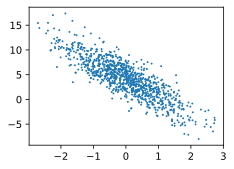

In [7]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

### 读取小批量数据

In [8]:
# batch大小，特征，标号
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [9]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.0942,  1.1918],
        [ 0.0665, -0.8385],
        [-1.2291,  0.3836],
        [ 0.4997,  1.2079],
        [ 1.3222,  0.4888],
        [ 1.1321,  0.9223],
        [ 1.0370, -0.0594],
        [ 0.5457,  0.7610],
        [-0.2281,  0.2310],
        [-1.1481, -0.8899]]) 
 tensor([[2.3335],
        [7.1834],
        [0.4204],
        [1.0910],
        [5.1834],
        [3.3213],
        [6.4846],
        [2.6921],
        [2.9693],
        [4.9313]])


### 定义初始化模型参数

In [19]:
# 采用均值为0 标准差0.01正态分布中采样随机数来初始化权重
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# 目标是更新 w 和 b

### 定义模型

In [11]:
def linreg(X, w, b): 
    """线性回归模型"""
    return torch.matmul(X, w) + b

### 定义损失函数

In [20]:
# 平方损失函数
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 定义优化算法

In [13]:
# 朝减少损失的方向更新参数
# 小批量随机梯度下降更新
def sgd(params, lr, batch_size): 
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 训练过程

In [21]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

# 训练的过程都是两层for loop
for epoch in range(num_epochs):
    # 遍历整个数据集
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.038000
epoch 2, loss 0.000143
epoch 3, loss 0.000053


In [22]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0002, -0.0014], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)
